In [1]:
import matplotlib.pyplot as     plt
import matplotlib        as     mpl
import numpy             as     np
import pandas            as     pd
import xarray            as     xr
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import yaml
import sys
import os
import netCDF4
import warnings

from   pylab             import cm
from   scipy             import ndimage
warnings.filterwarnings("ignore")

sys.path.append('/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/python_modules')
from domain         import generate_domain_coord
from domain         import convert_latlon_to_domain_indices
from satellite      import extract_satellite_track

In [2]:
def convert_calipso_data_in_2D(ncfile, varname, coord_domain, ni, nj):

    track   = extract_satellite_track(ncfile, coord_domain, 'calipso')
    indices = convert_latlon_to_domain_indices(track, 'NAM11')

    nc      = netCDF4.Dataset(ncfile,'r')
    data    = nc[varname][track['index']]

    data_sum  = np.ones((655,655)) * 0
    data_n    = np.ones((655,655)) * 0
    for i in range(len(indices['i'])): 
        I = indices['i'][i]
        J = indices['j'][i]
        data_sum[I, J] = data_sum[I, J] + data[i]
        data_n[  I, J] = data_n[  I, J] + 1
    return data_sum/data_n

In [3]:
dpi = 150
data_dir = 'pampa/poitras/DATA'
gemname              = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes"
# Step 0 GEM path to set lat and lon in cartopy
step_0 = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes_step0"
ncfile = '/{}/GEM5/{}/Samples_NetCDF/{}/pm2013010100_00000000p.nc'.format(data_dir,gemname,step_0)

# Get lat, lon and cartopy_projection_object
ds  = xr.open_dataset(ncfile) # Dataframe from the netcdf file
lat = ds.lat.values           # 2D array with latitude
lon = ds.lon.values           # 2D array with longitude
m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude, ds.rotated_pole.grid_north_pole_latitude)
xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())
L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')

def plot_map_tracks(tot_cover, high_cover, mid_cover, low_cover):
    fig = plt.figure(figsize=(15, 15), constrained_layout = True)
    ##########################################################################################################
    ###                                    Creating a discrete colorbar                                    ###
    ##########################################################################################################
    # Discrete colors                                                                                      ###
    cm = plt.get_cmap('viridis', 10)                                                                       ###
    #cm = plt.get_cmap('seismic', 11)                                                                      ###
    # Discrete color increment values                                                                      ###
    bounds_maps  = np.linspace(0, 1, 11)                                                                   ###                                                                  
    #bounds_maps  = np.linspace(-1, 1, 11)                                                                 ###                                                                  
    # Norm                                                                                                 ###
    norm_maps    = mpl.colors.BoundaryNorm(bounds_maps, cm.N)                                              ###
    ##########################################################################################################

    #############################
    ###        MODIS          ###
    #############################

    ###########################################################################
    l1 = 0.02; l2 = 0.26; l3 = 0.50 ;l4= 0.74                               ### 
    h  = 0.23; w  = 0.23 # h = height, w = width of the subplots (fraction) ###
    b  = 0.73            # b = bottom height                                ###
    fs = 13              # Fontsize for titles                              ###
    ###########################################################################
    # First subplot
    ax1 = plt.axes([l1, b, w, h],projection=m)
    ax1.set_extent([xll, xur, yll, yur], crs = m)
    ax1.set_title('Total Cloud Cover', fontsize = 20)
    ax1.coastlines()
    ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
    MODIS_t = ax1.pcolormesh(lon, lat,tot_cover, cmap=cm, transform=ccrs.PlateCarree(), norm = norm_maps)

    # Second subplot
    ax2 = plt.axes([l2, b, w, h],projection=m)
    ax2.set_extent([xll, xur, yll, yur], crs = m)
    ax2.set_title('High Cloud Cover', fontsize = 20)
    ax2.coastlines()
    ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
    ax2.pcolormesh(lon, lat,high_cover, cmap=cm, transform=ccrs.PlateCarree(), norm = norm_maps)

    # Third subplot
    ax3 = plt.axes([l3, b, w, h],projection=m)
    ax3.set_extent([xll, xur, yll, yur], crs = m)
    ax3.set_title('Mid Cloud Cover', fontsize = 20)
    ax3.coastlines()
    ax3.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
    ax3.pcolormesh(lon, lat, mid_cover, cmap=cm, transform=ccrs.PlateCarree(), norm = norm_maps)

    # Fourth subplot
    ax4 = plt.axes([l4, b, w, h],projection=m)
    ax4.set_extent([xll, xur, yll, yur], crs = m)
    ax4.set_title('Low Cloud Cover', fontsize = 20)
    ax4.coastlines()
    ax4.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
    ax4.pcolormesh(lon, lat, low_cover, cmap=cm, transform=ccrs.PlateCarree(), norm = norm_maps)

    #############################
    ###   Colorbar setting    ###
    #############################
    cb_l = 0.98
    #Colorbar             # [left,bottom,width,height]
    cbar_ax1 = fig.add_axes([cb_l, 0.73, 0.01, 0.23])
    cbar1    = fig.colorbar(MODIS_t, extend = 'neither', cax = cbar_ax1, ticks=bounds_maps, boundaries=bounds_maps)
    cbar1.ax.tick_params(labelsize=15)

    # Adjust the layout and display the plot
    plt.show()
    plt.close()

In [4]:
x = np.arange(-0.5,-0.5+399*0.06,0.06)
print(len(x))

399


# FILELIST TRACK IN DOMAIN

In [5]:
year     = 2014
period   = 'ANNUAL'
layerdef = 'pmaxran'

if   period == 'DJF'   : months = [ 1,  2, 12]
elif period == 'MAM'   : months = [ 3,  4,  5]
elif period == 'JJA'   : months = [ 6,  7,  8]
elif period == 'SON'   : months = [ 9, 10, 11]
elif period == 'ANNUAL': months = [ 1,  2,  3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
else:                    months = [ int(period) ]

dirlist = '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/5_CALIPSO_GEM5_COSP_common_track'    
### 2014 FILELIST ###
f_list_2014   = dirlist + '/' + '2014.txt'
df_14         = pd.read_csv(f_list_2014,delimiter='\s+', header=None)
df_14.columns = ['file', 'ndata', 'ti', 'tf', 'date', 'MM', 'date_gem', 't_gem']
df_14         = df_14[   np.isin(df_14['MM'], months)  ].reset_index(drop=True)

### 2015 FILELIST ###
f_list_2015 = dirlist + '/' + '2015.txt'
df_15         = pd.read_csv(f_list_2015,delimiter='\s+', header=None)
df_15.columns = ['file', 'ndata', 'ti', 'tf', 'date', 'MM', 'date_gem', 't_gem']
df_15         = df_15[   np.isin(df_15['MM'], months)  ].reset_index(drop=True)

### COMPLETE filelist 2014-2015
filelist   = dirlist + '/' + '2014_2015.txt'
df         = pd.read_csv(filelist,delimiter='\s+', header=None)
df.columns = ['file', 'ndata', 'ti', 'tf', 'date', 'MM', 'date_gem', 't_gem']
df         = df[   np.isin(df['MM'], months)  ].reset_index(drop=True)

In [6]:
print(df)

                                                    file  ndata  \
0      /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...    166   
1      /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...    894   
2      /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...   1593   
3      /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...   1601   
4      /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...   1688   
...                                                  ...    ...   
12740  /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...    240   
12741  /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...   1445   
12742  /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...    150   
12743  /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...    314   
12744  /pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPr...      9   

                   ti              tf          date  MM  date_gem  t_gem  
0      20140101032117  20140101032320  201401010300   1  20140101      2  
1      20140101045713  20140101050818  201401

# FILEPATH OF CALIPSO,GEM & COSP

In [6]:
# Directory in
pm                   = "pm2013010100"
data_dir = 'pampa/poitras/DATA'
gemname              = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes"

filepath_GEM     = "/{}/GEM5/{}/Samples_NetCDF/{}_YYYYMM/{}_YYYYMMDDd.nc".format(data_dir,gemname,gemname,pm)
#filepath_CALIPSO = '/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF_LowMidHigh/pmax/YYYY' 
filepath_CALIPSO = '/chinook/veilleux/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF_LowMidHigh/pmaxran/YYYY'
filepath_COSP    ='/pampa/poitras/DATA/COSP2/COSPOUT/{}/NAM11/M01SC002/CALIPSO/calipso_cloudmap/YYYYMM/cospout_YYYYMMDDHH00_2D.nc'.format(gemname)
# Directory out
diro = '/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/'+ layerdef

# CREATING DICTIONNARY

In [17]:
datasets             = ['calipso','gem','cosp']
layers               = ['t','h','m','l']

n    = {}
sum_data  = {}
data = {}
for dataset in datasets:
    sum_data  [dataset] = {}
    data [dataset] = {}
    for layer in layers:
        n            [layer]      = np.zeros((655,655))
        sum_data [dataset][layer] = np.zeros((655,655))
        data[dataset][layer]      = np.zeros((655,655))
common_mask = {}

In [22]:
print(n)
print(sum_data)

{'t': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'h': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'm': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'l': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}
{'calipso':

# Masking CALIPSO DATA over COSP and GEM data

In [8]:
df = df_14
for i in range(len(df)):
    t_gem        = df['t_gem'   ][i]
    YYYY_gem     = str(df['date_gem'][i])[0:4]
    YYYYMMDD_gem = str(df['date_gem'][i])
    YYYYMM_gem   = str(df['date_gem'][i])[0:6]
    date         = str(df['date'    ][i])
    MM           = str(df['date_gem'][i])[4:6]
    CALIPSO_file = df['file'][i].split('/')[8]
    
    CALIPSO_nc   = filepath_CALIPSO.replace('YYYY',YYYY_gem) +'/'+ CALIPSO_file
    GEM5_nc      = filepath_GEM.replace('YYYYMMDD',YYYYMMDD_gem).replace('YYYYMM',YYYYMM_gem)
    COSP_nc      = filepath_COSP.replace('YYYYMMDD',str(date)[0:8]).replace('HH',str(date)[8:10]).replace('YYYYMM',str(date)[0:6])

    if  os.path.exists(CALIPSO_nc) and os.path.exists(GEM5_nc) and os.path.exists(COSP_nc):
        # CALIPSO, GEM5 & COSP datasets
        ds_CALIPSO = netCDF4.Dataset(CALIPSO_nc, 'r')
        ds_GEM5    = netCDF4.Dataset(GEM5_nc   , 'r')
        ds_COSP    = netCDF4.Dataset(COSP_nc   , 'r')

        ########################################################
        ######                 CALIPSO                    ######
        ########################################################
        coord_NAM11   = generate_domain_coord('NAM11')
        data['calipso']['t']   = convert_calipso_data_in_2D(CALIPSO_nc,  'Tot_cloud_cover', coord_NAM11, 655, 655)
        data['calipso']['h']   = convert_calipso_data_in_2D(CALIPSO_nc, 'High_cloud_cover', coord_NAM11, 655, 655)
        data['calipso']['m']   = convert_calipso_data_in_2D(CALIPSO_nc,  'Mid_cloud_cover', coord_NAM11, 655, 655)
        data['calipso']['l']   = convert_calipso_data_in_2D(CALIPSO_nc,  'Low_cloud_cover', coord_NAM11, 655, 655)
        #CALIPSO mask        
        calipso_mask_t   = np.where(np.isnan(data['calipso']['t']), 0, 1)
        calipso_mask_h   = np.where(np.isnan(data['calipso']['h']), 0, 1)
        calipso_mask_m   = np.where(np.isnan(data['calipso']['m']), 0, 1)
        calipso_mask_l   = np.where(np.isnan(data['calipso']['l']), 0, 1)

        data['calipso']['t'][np.isnan(data['calipso']['t'])] = 0
        data['calipso']['h'][np.isnan(data['calipso']['h'])] = 0
        data['calipso']['m'][np.isnan(data['calipso']['m'])] = 0
        data['calipso']['l'][np.isnan(data['calipso']['l'])] = 0
        
        calipso_mask_82deg = np.where(np.array(ds_GEM5['lat']) >= 82, np.nan,1)
 
        data['calipso']['t'] = data['calipso']['t'] * calipso_mask_82deg
        data['calipso']['h'] = data['calipso']['h'] * calipso_mask_82deg
        data['calipso']['m'] = data['calipso']['m'] * calipso_mask_82deg
        data['calipso']['l'] = data['calipso']['l'] * calipso_mask_82deg
        
        ########################################################
        ######                    GEM5                    ######
        ########################################################
        data['gem']['t']    = ds_GEM5['TCCM'][t_gem]
        data['gem']['h']    = ds_GEM5['TZHM'][t_gem]
        data['gem']['m']    = ds_GEM5['TZMM'][t_gem]
        data['gem']['l']    = ds_GEM5['TZLM'][t_gem]
        
        missing_GEM_value_t = ds_GEM5['TCCM'].getncattr('_FillValue')
        missing_GEM_value_h = ds_GEM5['TZHM'].getncattr('_FillValue')
        missing_GEM_value_m = ds_GEM5['TZMM'].getncattr('_FillValue')
        missing_GEM_value_l = ds_GEM5['TZLM'].getncattr('_FillValue')
        
        data['gem']['t']    = data['gem']['t'] * calipso_mask_t * calipso_mask_82deg
        data['gem']['h']    = data['gem']['h'] * calipso_mask_h * calipso_mask_82deg
        data['gem']['m']    = data['gem']['m'] * calipso_mask_m * calipso_mask_82deg
        data['gem']['l']    = data['gem']['l'] * calipso_mask_l * calipso_mask_82deg
        
        G_mask_t   = np.where(data['gem']['t'] == missing_GEM_value_t, 0 , 1)
        G_mask_h   = np.where(data['gem']['h'] == missing_GEM_value_h, 0 , 1)
        G_mask_m   = np.where(data['gem']['m'] == missing_GEM_value_m, 0 , 1)
        G_mask_l   = np.where(data['gem']['l'] == missing_GEM_value_l, 0 , 1)
        
        #data['gem']['t'][data['gem']['t'] == missing_GEM_value_t] = 0
        #data['gem']['h'][data['gem']['h'] == missing_GEM_value_h] = 0
        #data['gem']['m'][data['gem']['m'] == missing_GEM_value_m] = 0
        #data['gem']['l'][data['gem']['l'] == missing_GEM_value_l] = 0
        
        data['gem']['t'] = data['gem']['t']* G_mask_t
        data['gem']['h'] = data['gem']['h']* G_mask_h
        data['gem']['m'] = data['gem']['m']* G_mask_m
        data['gem']['l'] = data['gem']['l']* G_mask_l

        ########################################################
        ######                   COSP2                    ######
        ########################################################
        data['cosp']['t'] = np.array(ds_COSP['cltcalipso'][:].T/100) * calipso_mask_t * calipso_mask_82deg
        data['cosp']['h'] = np.array(ds_COSP['clhcalipso'][:].T/100) * calipso_mask_h * calipso_mask_82deg
        data['cosp']['m'] = np.array(ds_COSP['clmcalipso'][:].T/100) * calipso_mask_m * calipso_mask_82deg
        data['cosp']['l'] = np.array(ds_COSP['cllcalipso'][:].T/100) * calipso_mask_l * calipso_mask_82deg
        
        missing_value_COSP = -1.000000062271131e+28
        
        COSP_mask_t  = np.where(data['cosp']['t'] == missing_value_COSP, 0, 1)
        COSP_mask_h  = np.where(data['cosp']['h'] == missing_value_COSP, 0, 1)
        COSP_mask_m  = np.where(data['cosp']['m'] == missing_value_COSP, 0, 1)
        COSP_mask_l  = np.where(data['cosp']['l'] == missing_value_COSP, 0, 1)

        data['cosp']['t'] = data['cosp']['t'] * COSP_mask_t 
        data['cosp']['h'] = data['cosp']['h'] * COSP_mask_h
        data['cosp']['m'] = data['cosp']['m'] * COSP_mask_m
        data['cosp']['l'] = data['cosp']['l'] * COSP_mask_l
        
        #print(YYYYMMDD_gem,t_gem) 
        #print('CALIPSO')
        #plot_map_tracks(data['calipso']['t'],data['calipso']['h'], data['calipso']['m'],data['calipso']['l'])
        #print('GEM5')
        #plot_map_tracks(data['gem']    ['t'],data['gem']    ['h'], data['gem']    ['m'],data['gem']    ['l'])
        #print('COSP')
        #plot_map_tracks(data['cosp']['t']   ,data['cosp']   ['h'], data['cosp']   ['m'],data['cosp']   ['l'])
        
        common_mask['t'] = calipso_mask_t * G_mask_t * calipso_mask_82deg
        common_mask['h'] = calipso_mask_h * G_mask_h * calipso_mask_82deg
        common_mask['m'] = calipso_mask_m * G_mask_m * calipso_mask_82deg
        common_mask['l'] = calipso_mask_l * G_mask_l * calipso_mask_82deg
        #print('COMMON MASK')
        #plot_map_tracks(common_mask['t'],common_mask['t'],common_mask['t'],common_mask['t'])
        
        for layer in layers:
            n[layer] = n[layer] + common_mask[layer]
            for dataset in datasets:
                sum_data[dataset][layer] = sum_data[dataset][layer] + data[dataset][layer]

KeyboardInterrupt: 

# OUTPUT FILE

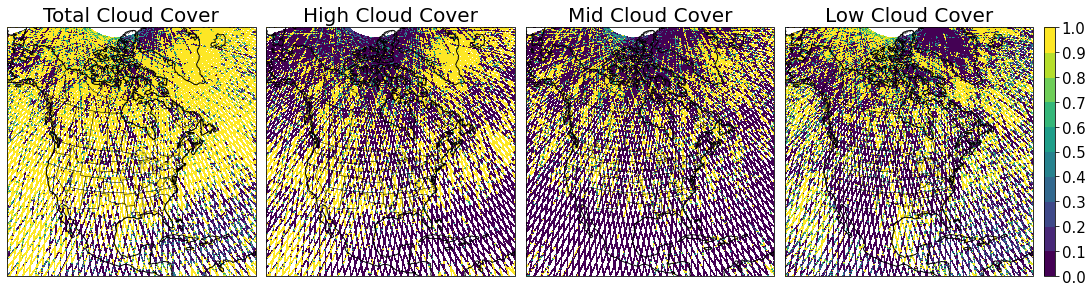

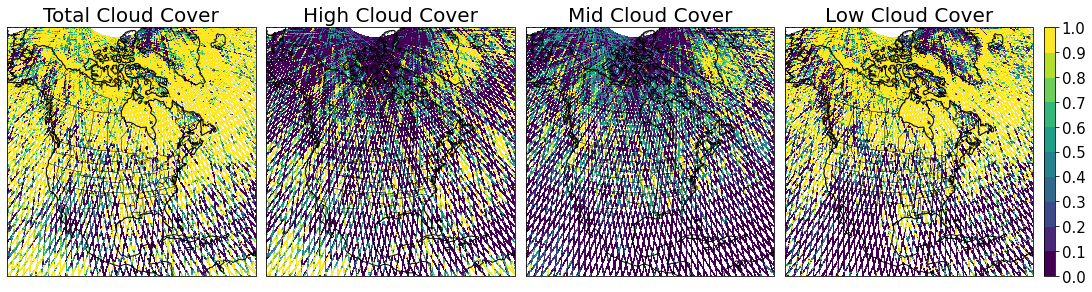

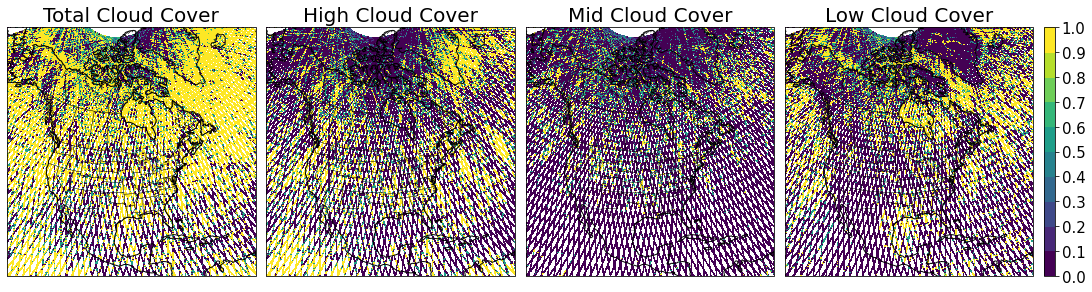

629 277
629 277


In [35]:
plot_map_tracks(sum_data['calipso']['t']/n['t'],sum_data['calipso']['h']/n['h'],sum_data['calipso']['m']/n['m'],sum_data['calipso']['l']/n['l'])
plot_map_tracks(sum_data['gem']    ['t']/n['t'],sum_data['gem']    ['h']/n['h'],sum_data['gem']    ['m']/n['m'],sum_data['gem']    ['l']/n['l'])
plot_map_tracks(sum_data['cosp']   ['t']/n['t'],sum_data['cosp']   ['h']/n['h'],sum_data['cosp']   ['m']/n['m'],sum_data['cosp']   ['l']/n['l'])

I,J  = np.unravel_index(n['t'].argmax(), n['t'].shape)
i,j = np.unravel_index(sum_data['calipso']['t'].argmax(), sum_data['calipso']['t'].shape)

print(i,j)
print(I,J)


In [21]:
window = int(29)

CALIPSO = []
GEM5    = []
COSP    = []

for varname in ['t','h','m','l']:
    print(varname)
    'Computing temoral mean: at this point we still to have only tracks'
    data_temporal_mean_CALIPSO   = sum_data['calipso'][varname] / n[varname]
    data_temporal_mean_GEM5      = sum_data['gem']    [varname] / n[varname]
    data_temporal_mean_COSP      = sum_data['cosp']   [varname] / n[varname]
    
    'Computing spatial mean over a square of size window x window'
    data_spatial_mean_CALIPSO    = ndimage.generic_filter(data_temporal_mean_CALIPSO, np.nanmean, size=window, mode='constant',cval=np.nan)
    data_spatial_mean_GEM5       = ndimage.generic_filter(data_temporal_mean_GEM5   , np.nanmean, size=window, mode='constant',cval=np.nan) 
    data_spatial_mean_COSP       = ndimage.generic_filter(data_temporal_mean_COSP   , np.nanmean, size=window, mode='constant',cval=np.nan) 

    CALIPSO.append(data_spatial_mean_CALIPSO)
    GEM5.append   (data_spatial_mean_GEM5   )
    COSP.append   (data_spatial_mean_COSP   )

t
h
m
l


In [22]:
c_bias_t = np.subtract(sum_data['cosp']['t'] / n['t'], sum_data['calipso']['t']/ n['t'])**2
c_bias_h = np.subtract(sum_data['cosp']['h'] / n['h'], sum_data['calipso']['h']/ n['h'])**2
c_bias_m = np.subtract(sum_data['cosp']['m'] / n['m'], sum_data['calipso']['m']/ n['m'])**2
c_bias_l = np.subtract(sum_data['cosp']['l'] / n['l'], sum_data['calipso']['l']/ n['l'])**2

g_bias_t = np.subtract(sum_data['gem']['t'] / n['t'], sum_data['calipso']['t']/ n['t'])**2
g_bias_h = np.subtract(sum_data['gem']['h'] / n['h'], sum_data['calipso']['h']/ n['h'])**2
g_bias_m = np.subtract(sum_data['gem']['m'] / n['m'], sum_data['calipso']['m']/ n['m'])**2
g_bias_l = np.subtract(sum_data['gem']['l'] / n['l'], sum_data['calipso']['l']/ n['l'])**2

print(np.nanmean(c_bias_t)*100)
print(np.nanmean(c_bias_h)*100)
print(np.nanmean(c_bias_m)*100)
print(np.nanmean(c_bias_l)*100)
print('###########################')
print(np.nanmean(g_bias_t)*100)
print(np.nanmean(g_bias_h)*100)
print(np.nanmean(g_bias_m)*100)
print(np.nanmean(g_bias_l)*100)
print('###########################')



for dataset in ['calipso','gem','cosp']:
    for layer in ['t','h','m','l']:
        
        print('{}_max_{}:'.format(dataset,layer), np.nanmax(sum_data[dataset][layer]/n[layer]))
        print('{}_min_{}:'.format(dataset,layer), np.nanmin(sum_data[dataset][layer]/n[layer]))

18.812510000137912
16.685152734175393
19.60694178565517
23.48714261264508
###########################
16.13295352108862
14.701715036226865
14.690125278350418
25.55555824072701
###########################
calipso_max_t: 1.0
calipso_min_t: 0.0
calipso_max_h: 1.0
calipso_min_h: 0.0
calipso_max_m: 1.0
calipso_min_m: 0.0
calipso_max_l: 1.0
calipso_min_l: 0.0
gem_max_t: 1.0
gem_min_t: 0.0
gem_max_h: 1.0
gem_min_h: 0.0
gem_max_m: 1.0
gem_min_m: 0.0
gem_max_l: 1.0
gem_min_l: 0.0
cosp_max_t: 1.0
cosp_min_t: 0.0
cosp_max_h: 1.0
cosp_min_h: 0.0
cosp_max_m: 1.0
cosp_min_m: 0.0
cosp_max_l: 1.0
cosp_min_l: 0.0


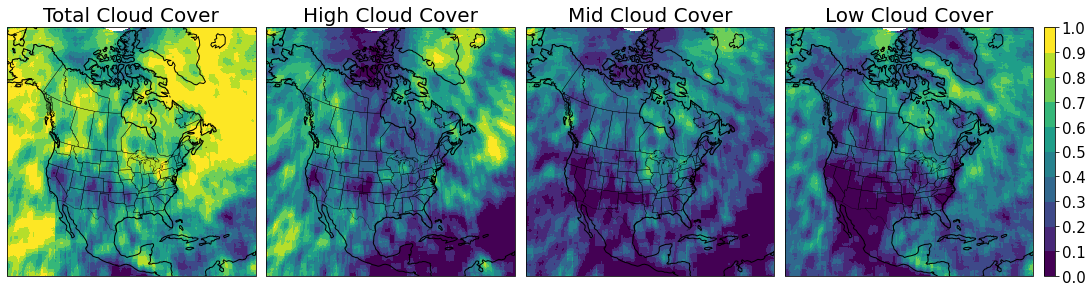

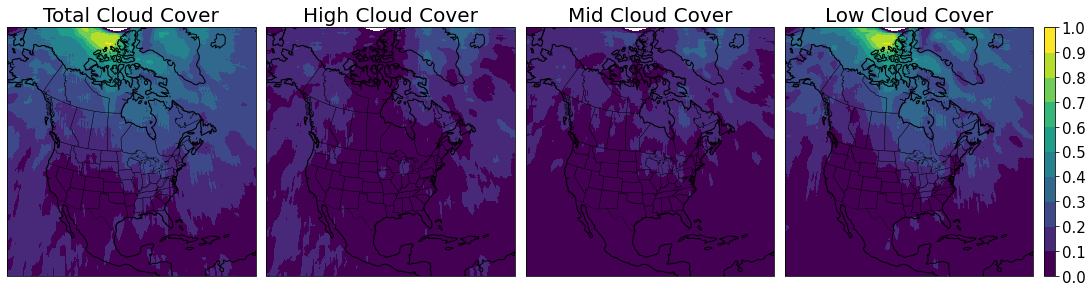

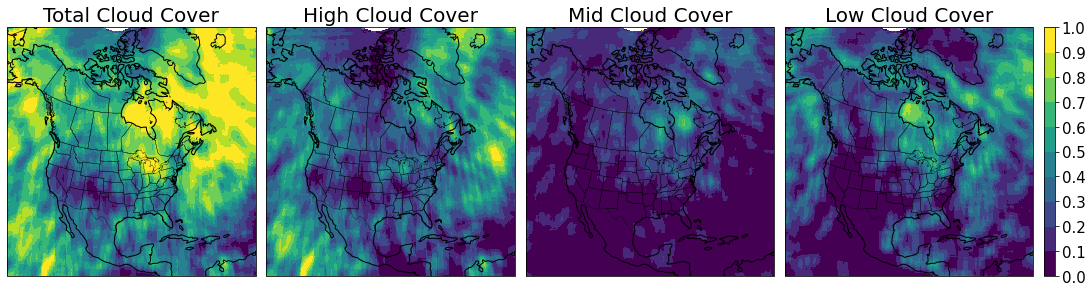

In [23]:
plot_map_tracks(CALIPSO[0],CALIPSO[1],CALIPSO[2],CALIPSO[3])
plot_map_tracks(GEM5   [0],GEM5   [1],GEM5   [2],GEM5   [3])
plot_map_tracks(COSP   [0],COSP   [1],COSP   [2],COSP   [3])

In [36]:
print(year)
print(str(period).zfill(2))


2014
02


In [37]:
YYYY = year
MM   = str(period).zfill(2)
#################################################################################################################
###                                              CREATING OUTPUT (ncfile)                                     ###
#################################################################################################################
nci = '/pampa/poitras/DATA/GEM5/COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes/Samples_NetCDF/COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes_201401/pm2013010100_20140101d.nc'
nc = netCDF4.Dataset(nci, 'r')
ncfileo = diro + '/{}_{}.nc'.format(YYYY,MM)
print(diro)
nco     = netCDF4.Dataset(ncfileo , 'w')
# Copying global attributes
nco.setncatts(nc.__dict__)

# Creating dimensions
dimnames = [ dim for dim in nc.dimensions ]
for dimname in dimnames:
    #print(dimname)
    dimension = nc.dimensions[dimname]
    nco.createDimension(dimname, (len(dimension) if not dimension.isunlimited() else None))

# Creating 'old' variables
varnames = [ var for var in nc.variables ]
for varname in varnames:
    if varname in [ 'lon', 'lat', 'rlon', 'rlat', 'rotated_pole' ]:
        variable = nc[varname]
        x = nco.createVariable(varname, variable.datatype, variable.dimensions, zlib=True, complevel=4)
        nco[varname].setncatts(variable.__dict__)


# Creating 'new' variables
variable = nc['lon']
layer_names = ['Tot_cloud_cover','High_cloud_cover','Mid_cloud_cover','Low_cloud_cover']
for layer in layers:
    for dataset in datasets:
        varname = dataset +'_'+layer_names[layers.index(layer)] + '_' + layer
        x = nco.createVariable(varname , variable.datatype, variable.dimensions, zlib=True, complevel=4)

for layer in layers:
    varname = 'n_' + layer
    x = nco.createVariable(varname , variable.datatype, variable.dimensions, zlib=True, complevel=4)

# Copying values for the 'old' variables
varnames = [ var for var in nc.variables ]
for varname in varnames:
    if varname in [ 'lon', 'lat', 'rlon', 'rlat', 'rotated_pole' ]:
        #print(varname, nc[varname][:])
        nco[varname][:] = nc[varname][:]

# Filling values for the 'new' variables
layer_names = ['Tot_cloud_cover','High_cloud_cover','Mid_cloud_cover','Low_cloud_cover']
for dataset in datasets:
        for layer in layers:
            varname = dataset +'_'+layer_names[layers.index(layer)]  +'_' + layer
            nco[varname][:] = sum_data[dataset][layer]

for layer in layers:
    varname = 'n_' + layer
    nco[varname][:] =  n[layer]
    print(np.nanmin(n[layer]))
    print(np.nanmax(n[layer]))

nco.close()

/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran
0.0
16.0
0.0
16.0
0.0
16.0
0.0
16.0


In [10]:
#########################################################################
# Configuration file (yml)                                              #
#########################################################################
layerdef = 'pmaxran'
working_directory = '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/'
yml_file = working_directory + 'config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)

domain  = config['domain' ]
dirout  = config['CALIPSOvsCOSP2vsGEM5_maps']['NetCDF'] +'/'+layerdef
dirlist = config['CALIPSO']['list']   + '/' + domain

pm      = "pm2013010100"
gemname = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes"

# Initializing filepath to modify in the loop
filepath_GEM     = config['GEM5']['NetCDF'] + '{}_YYYYMM/'.format(gemname)+'{}_YYYYMMDDd.nc'.format(pm)
filepath_CALIPSO = config['CALIPSO_CHINOOK']['NetCDF'] + '_LowMidHigh/' + layerdef +'/YYYY'
filepath_COSP    = config['COSP2']['output']+ domain + '/M01SC002/CALIPSO/calipso_cloudmap/YYYYMM/cospout_YYYYMMDDHH00_2D.nc'


In [14]:
print(filepath_CALIPSO)

/chinook/veilleux/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF_LowMidHigh/pmaxran/YYYY


In [16]:
print(filepath_GEM)

/pampa/poitras/DATA/GEM5/COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes/Samples_NetCDFCOSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes_YYYYMM/pm2013010100_YYYYMMDDd.nc


In [15]:
print(filepath_COSP)

/pampa/poitras/DATA/COSP2/COSPOUT/COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_LakesNAM11/M01SC002/CALIPSO/calipso_cloudmap/YYYYMM/cospout_YYYYMMDDHH00_2D.nc


In [13]:
print(dirout)
print('/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran')

/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran
/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran


In [31]:
import matplotlib.pyplot as     plt
import matplotlib        as     mpl
import numpy             as     np
import pandas            as     pd
import xarray            as     xr
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import yaml
import sys
import os
import netCDF4
import warnings

from   pylab             import cm
from   scipy             import ndimage
warnings.filterwarnings("ignore")

sys.path.append('/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/python_modules')
from domain         import generate_domain_coord
from domain         import convert_latlon_to_domain_indices
from satellite      import extract_satellite_track


#################################################################################################################
##########                                           FUNCTIONS                                       ############
#################################################################################################################
def create_dataframe(dirlist, YYYYMM):
    # Create a dataframe containg only the files of YYYYMM 
    YYYY =     str(YYYYMM[0:4])
    MM   = int(str(YYYYMM[4:6]))

    filelist   = dirlist + '/' + YYYY + '.txt'
    df         = pd.read_csv(filelist,delimiter='\s+', header=None)
    df.columns = ['file', 'ndata', 'ti', 'tf', 'date', 'MM', 'date_gem', 't_gem']
    df         = df[   np.isin(df['MM'], MM)  ].reset_index(drop=True)
    return df

def convert_calipso_data_in_2D(ncfile, varname, coord_domain, ni, nj):

    track   = extract_satellite_track(ncfile, coord_domain, 'calipso')
    indices = convert_latlon_to_domain_indices(track, 'NAM11')

    nc      = netCDF4.Dataset(ncfile,'r')
    data    = nc[varname][track['index']]

    data_sum  = np.ones((655,655)) * 0
    data_n    = np.ones((655,655)) * 0
    for i in range(len(indices['i'])): 
        I = indices['i'][i]
        J = indices['j'][i]
        data_sum[I, J] = data_sum[I, J] + data[i]
        data_n[  I, J] = data_n[  I, J] + 1
    return data_sum/data_n

def monthly_mean(df, filepath_CALIPSO, filepath_GEM, filepath_COSP):
    ########################################################
    ####          Initializing data arrays              ####
    ########################################################
    datasets = ['calipso','gem','cosp']
    layers = ['t','h','m','l']

    n    = {}
    sum_data  = {}
    data = {}
    for dataset in datasets:
        sum_data  [dataset] = {}
        data [dataset] = {}
        for layer in layers:
            n [layer]                = np.zeros((655,655))
            sum_data[dataset][layer] = np.zeros((655,655))
            data[dataset][layer]     = np.zeros((655,655))
    common_mask = {}
    ########################################################
    ########################################################
  
    for i in range(len(df)):
        t_gem        = df['t_gem'   ][i]
        YYYY_gem     = str(df['date_gem'][i])[0:4]
        YYYYMMDD_gem = str(df['date_gem'][i])
        YYYYMM_gem   = str(df['date_gem'][i])[0:6]
        date         = str(df['date'    ][i])
        MM           = str(df['date_gem'][i])[4:6]
        CALIPSO_file = df['file'][i].split('/')[8]

        CALIPSO_nc   = filepath_CALIPSO.replace('YYYY',YYYY_gem) +'/'+ CALIPSO_file
        GEM5_nc      = filepath_GEM.replace('YYYYMMDD',YYYYMMDD_gem).replace('YYYYMM',YYYYMM_gem)
        COSP_nc      = filepath_COSP.replace('YYYYMMDD',str(date)[0:8]).replace('HH',str(date)[8:10]).replace('YYYYMM',str(date)[0:6])
        #print(df)
        #input(' ')
        print(CALIPSO_nc)
        print(GEM5_nc)
        print(COSP_nc)
        if  os.path.exists(CALIPSO_nc) and os.path.exists(GEM5_nc) and os.path.exists(COSP_nc):
            # CALIPSO, GEM5 & COSP datasets
            ds_CALIPSO = netCDF4.Dataset(CALIPSO_nc, 'r')
            ds_GEM5    = netCDF4.Dataset(GEM5_nc   , 'r')
            ds_COSP    = netCDF4.Dataset(COSP_nc   , 'r')

            ########################################################
            ######                 CALIPSO                    ######
            ########################################################
            coord_NAM11   = generate_domain_coord('NAM11')
            data['calipso']['t']   = convert_calipso_data_in_2D(CALIPSO_nc,  'Tot_cloud_cover', coord_NAM11, 655, 655)
            data['calipso']['h']   = convert_calipso_data_in_2D(CALIPSO_nc, 'High_cloud_cover', coord_NAM11, 655, 655)
            data['calipso']['m']   = convert_calipso_data_in_2D(CALIPSO_nc,  'Mid_cloud_cover', coord_NAM11, 655, 655)
            data['calipso']['l']   = convert_calipso_data_in_2D(CALIPSO_nc,  'Low_cloud_cover', coord_NAM11, 655, 655)
            #CALIPSO mask        
            calipso_mask_t   = np.where(np.isnan(data['calipso']['t']), 0, 1)
            calipso_mask_h   = np.where(np.isnan(data['calipso']['h']), 0, 1)
            calipso_mask_m   = np.where(np.isnan(data['calipso']['m']), 0, 1)
            calipso_mask_l   = np.where(np.isnan(data['calipso']['l']), 0, 1)

            data['calipso']['t'][np.isnan(data['calipso']['t'])] = 0
            data['calipso']['h'][np.isnan(data['calipso']['h'])] = 0
            data['calipso']['m'][np.isnan(data['calipso']['m'])] = 0
            data['calipso']['l'][np.isnan(data['calipso']['l'])] = 0

            calipso_mask_82deg = np.where(np.array(ds_GEM5['lat']) >= 82, np.nan,1)

            data['calipso']['t'] = data['calipso']['t'] * calipso_mask_82deg
            data['calipso']['h'] = data['calipso']['h'] * calipso_mask_82deg
            data['calipso']['m'] = data['calipso']['m'] * calipso_mask_82deg
            data['calipso']['l'] = data['calipso']['l'] * calipso_mask_82deg

            ########################################################
            ######                    GEM5                    ######
            ########################################################
            data['gem']['t']    = ds_GEM5['TCCM'][t_gem]
            data['gem']['h']    = ds_GEM5['TZHM'][t_gem]
            data['gem']['m']    = ds_GEM5['TZMM'][t_gem]
            data['gem']['l']    = ds_GEM5['TZLM'][t_gem]

            missing_GEM_value_t = ds_GEM5['TCCM'].getncattr('_FillValue')
            missing_GEM_value_h = ds_GEM5['TZHM'].getncattr('_FillValue')
            missing_GEM_value_m = ds_GEM5['TZMM'].getncattr('_FillValue')
            missing_GEM_value_l = ds_GEM5['TZLM'].getncattr('_FillValue')

            data['gem']['t']    = data['gem']['t'] * calipso_mask_t * calipso_mask_82deg
            data['gem']['h']    = data['gem']['h'] * calipso_mask_h * calipso_mask_82deg
            data['gem']['m']    = data['gem']['m'] * calipso_mask_m * calipso_mask_82deg
            data['gem']['l']    = data['gem']['l'] * calipso_mask_l * calipso_mask_82deg

            G_mask_t   = np.where(data['gem']['t'] == missing_GEM_value_t, 0 , 1)
            G_mask_h   = np.where(data['gem']['h'] == missing_GEM_value_h, 0 , 1)
            G_mask_m   = np.where(data['gem']['m'] == missing_GEM_value_m, 0 , 1)
            G_mask_l   = np.where(data['gem']['l'] == missing_GEM_value_l, 0 , 1)

            data['gem']['t'] = data['gem']['t']* G_mask_t
            data['gem']['h'] = data['gem']['h']* G_mask_h
            data['gem']['m'] = data['gem']['m']* G_mask_m
            data['gem']['l'] = data['gem']['l']* G_mask_l

            ########################################################
            ######                   COSP2                    ######
            ########################################################
            data['cosp']['t'] = np.array(ds_COSP['cltcalipso'][:].T/100) * calipso_mask_t * calipso_mask_82deg
            data['cosp']['h'] = np.array(ds_COSP['clhcalipso'][:].T/100) * calipso_mask_h * calipso_mask_82deg
            data['cosp']['m'] = np.array(ds_COSP['clmcalipso'][:].T/100) * calipso_mask_m * calipso_mask_82deg
            data['cosp']['l'] = np.array(ds_COSP['cllcalipso'][:].T/100) * calipso_mask_l * calipso_mask_82deg

            missing_value_COSP = -1.000000062271131e+28

            COSP_mask_t  = np.where(data['cosp']['t'] == missing_value_COSP, 0, 1)
            COSP_mask_h  = np.where(data['cosp']['h'] == missing_value_COSP, 0, 1)
            COSP_mask_m  = np.where(data['cosp']['m'] == missing_value_COSP, 0, 1)
            COSP_mask_l  = np.where(data['cosp']['l'] == missing_value_COSP, 0, 1)

            data['cosp']['t'] = data['cosp']['t'] * COSP_mask_t 
            data['cosp']['h'] = data['cosp']['h'] * COSP_mask_h
            data['cosp']['m'] = data['cosp']['m'] * COSP_mask_m
            data['cosp']['l'] = data['cosp']['l'] * COSP_mask_l

            common_mask['t'] = calipso_mask_t * G_mask_t * calipso_mask_82deg
            common_mask['h'] = calipso_mask_h * G_mask_h * calipso_mask_82deg
            common_mask['m'] = calipso_mask_m * G_mask_m * calipso_mask_82deg
            common_mask['l'] = calipso_mask_l * G_mask_l * calipso_mask_82deg

            for layer in layers:
                n[layer] = n[layer] + common_mask[layer]
                for dataset in datasets:
                    sum_data[dataset][layer] = sum_data[dataset][layer] + data[dataset][layer]

    return data

def create_output_file(YYYY,MM,n,sum_data,data):
    datasets = ['calipso','gem','cosp']
    layers   = ['t','h','m','l']
    YYYY = YYYY
    MM   = str(MM).zfill(2)  
    print(YYYY,MM)
    #################################################################################################################
    ###                                              CREATING OUTPUT (ncfile)                                     ###
    #################################################################################################################
    # nc file in to configure output file
    nci = config['GEM5']['step0']
    nc = netCDF4.Dataset(nci, 'r')
    ncfileo = diro + '/{}{}.nc'.format(YYYY,MM)
    print(diro)
    nco     = netCDF4.Dataset(ncfileo , 'w')
    # Copying global attributes
    nco.setncatts(nc.__dict__)

    # Creating dimensions
    dimnames = [ dim for dim in nc.dimensions ]
    for dimname in dimnames:
        #print(dimname)
        dimension = nc.dimensions[dimname]
        nco.createDimension(dimname, (len(dimension) if not dimension.isunlimited() else None))

    # Creating 'old' variables
    varnames = [ var for var in nc.variables ]
    for varname in varnames:
        if varname in [ 'lon', 'lat', 'rlon', 'rlat', 'rotated_pole' ]:
            variable = nc[varname]
            x = nco.createVariable(varname, variable.datatype, variable.dimensions, zlib=True, complevel=4)
            nco[varname].setncatts(variable.__dict__)


    # Creating 'new' variables
    variable = nc['lon']
    layer_names = ['Tot_cloud_cover','High_cloud_cover','Mid_cloud_cover','Low_cloud_cover']
    for layer in layers:
        for dataset in datasets:
            varname = dataset +'_'+layer_names[layers.index(layer)] + '_' + layer
            x = nco.createVariable(varname , variable.datatype, variable.dimensions, zlib=True, complevel=4)

    for layer in layers:
        varname = 'n_' + layer
        x = nco.createVariable(varname , variable.datatype, variable.dimensions, zlib=True, complevel=4)

    # Copying values for the 'old' variables
    varnames = [ var for var in nc.variables ]
    for varname in varnames:
        if varname in [ 'lon', 'lat', 'rlon', 'rlat', 'rotated_pole' ]:
            #print(varname, nc[varname][:])
            nco[varname][:] = nc[varname][:]

    # Filling values for the 'new' variables
    layer_names = ['Tot_cloud_cover','High_cloud_cover','Mid_cloud_cover','Low_cloud_cover']
    for dataset in datasets:
            for layer in layers:
                varname = dataset +'_'+layer_names[layers.index(layer)]  +'_' + layer
                nco[varname][:] = sum_data[dataset][layer]

    for layer in layers:
        varname = 'n_' + layer
        nco[varname][:] =  n[layer]
        print(np.nanmin(n[layer]))
        print(np.nanmax(n[layer]))

#################################################################################################################
### MAIN ########################################################################################################
#################################################################################################################


#########################################################################
# Input arguments                                                       #
#########################################################################
working_directory =     '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/'
YYYYMM            =     '201401'
layerdef          =     'pmaxran'
overwrite         =     False

YYYY = int(str(YYYYMM[0:4]))
MM   = int(str(YYYYMM[4:6]))
print(YYYY,MM)

#########################################################################
# Configuration file (yml)                                              #
#########################################################################
yml_file = working_directory + '/config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)

domain  = config['domain' ]
dirout  = config['CALIPSOvsCOSP2vsGEM5_maps']['NetCDF']+'/'+ layerdef
dirlist = config['CALIPSO']['list']   + '/' + domain

pm               = "pm2013010100"
gemname          = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes"

# Initializing filepath to modify in the loop
filepath_GEM     = config['GEM5']['NetCDF'] +'/'+ '{}_YYYYMM/'.format(gemname)+'{}_YYYYMMDDd.nc'.format(pm)
filepath_CALIPSO = config['CALIPSO_CHINOOK']['NetCDF']+ '_LowMidHigh/'+ layerdef +'/YYYY'
filepath_COSP    = config['COSP2']['output'] +'/'+ domain + '/M01SC002/CALIPSO/calipso_cloudmap/YYYYMM/cospout_YYYYMMDDHH00_2D.nc'

if not os.path.exists(dirout): os.makedirs(dirout)

#Create a dataframe containing YYYYMM files
df_CALIPSO = create_dataframe(dirlist, YYYYMM)


m, sum_data = monthly_mean(df_CALIPSO, filepath_CALIPSO, filepath_GEM, filepath_COSP)


# Output data 
create_output_file(YYYY,MM,n,sum_data)


2014 1
{'calipso': {'t': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'h': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'm': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'l': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0.,

KeyboardInterrupt: 